In [95]:
%reset -f
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

def gatherData(stateName, dataDir):
    # Initialize accumulator datasets using CO California datasets
    # NOTE: Dataset fragments are all in './StateAirData/'
    colidx = [0,2,4,17]
    innerkeys = ['Date', 'Site ID', 'COUNTY']       # Merge on Date, Site ID, and County
    dataA2020 = pd.read_csv(dataDir + stateName + '-2020-co.csv', parse_dates=True, usecols=colidx)
    dataA2021 = pd.read_csv(dataDir + stateName + '-2021-co.csv', parse_dates=True, usecols=colidx)
    dataA2022 = pd.read_csv(dataDir + stateName + '-2022-co.csv', parse_dates=True, usecols=colidx)

    # Iterate through the directory using os.scandir, and then get all the datasets there
    # Merge the remaining datasets other than ca-year-co to dataAyear
    with os.scandir(dataDir) as datasets:
        for dataset in datasets:
            if dataset.is_file() and 'co' not in dataset.name:
                temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
                if stateName + '-2020' in dataset.name:
                    dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
                elif stateName + '-2021' in dataset.name:
                    dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
                elif stateName + '-2022' in dataset.name:
                    dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

    # At this point, dataA2020, dataA2021, and dataA2022 have accumulated the dataset year fragments.

    # Parse Date to date
    dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
    dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
    dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])

    # Group data by Date and Site ID, then by Date again to remove the Site ID feature
    # Result would be mean measurements per day
    dataA2020 = dataA2020.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()
    dataA2021 = dataA2021.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()
    dataA2022 = dataA2022.drop(columns=['Site ID'], axis=1).groupby(by=['Date'], as_index=False).mean()

    dataA = pd.concat([dataA2020, dataA2021, dataA2022])    # Combine the three datasets

    # Append State column to the data
    # dataA['State'] = stateName
    dataA.insert(1, 'State', stateName.upper(), True)

    return dataA

dataA = gatherData('ca', 'StateAirData/')
dataA = pd.concat([dataA, gatherData('ny', 'StateAirData/')])
dataA


,Date,State,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667
...,...,...,...,...,...,...,...,...,...
360,2022-12-27,NY,0.280000,25.600000,0.029417,NaN,NaN,10.024000,2.141667
361,2022-12-28,NY,0.330769,32.820000,0.029069,NaN,NaN,11.547368,1.475000
362,2022-12-29,NY,0.440000,36.237500,0.028200,NaN,NaN,15.096000,1.500000
363,2022-12-30,NY,0.590000,43.175000,0.025435,NaN,NaN,18.468000,1.066667


In [96]:
new_names = ['Date', 'State', 'CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

print("dataA columns renamed:")
dataA.head()

dataA columns renamed:


,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


In [97]:
import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

A: Number of entries with null values: 1455
A: Number of entries: 2192


In [98]:
# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Other estimators (estimator = func()) to try
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize imputer
# NOTE: DIFFERENT ESTIMATORS WERE TRIED HERE, from DecisionTreeRegressor() to KNeighborsRegressor()
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())

# Perform imputation (note that convergence was quickly reached, indicating a good imputation)
# Imputation done separately from dataB to ensure impartiality of resulting values
backup = pd.DataFrame().assign(Date=dataA['Date'], State=dataA['State'])
dataA.drop(['Date', 'State'], axis=1, inplace=True)

dataA[:] = imp.fit_transform(dataA)

print("After imputation:")
dataA.head()
print("A: Number of entries with null values after impute:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

dataA.insert(0, 'Date', backup.Date)
dataA.insert(1, 'State', backup.State)

dataA

[IterativeImputer] Completing matrix with shape (2192, 7)
[IterativeImputer] Change: 64.64497222967971, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Change: 0.23070221731362936, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Change: 0.00092463107158367, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Early stopping criterion reached.
After imputation:


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667


A: Number of entries with null values after impute: 0
A: Number of entries: 2192


,Date,State,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
0,2020-01-01,CA,0.636559,21.474615,0.030969,0.008000,20.491525,15.203015,0.972549
1,2020-01-02,CA,0.697647,26.564463,0.028227,0.013000,18.468085,12.619178,1.077083
2,2020-01-03,CA,0.845238,31.382500,0.026872,0.018990,21.129032,14.427778,1.044681
3,2020-01-04,CA,1.049138,32.154152,0.029897,0.011074,29.707692,16.439510,0.983929
4,2020-01-05,CA,0.792941,22.521138,0.032683,0.009000,13.905263,10.883221,0.766667
...,...,...,...,...,...,...,...,...,...
360,2022-12-27,NY,0.280000,25.600000,0.029417,0.015644,25.998143,10.024000,2.141667
361,2022-12-28,NY,0.330769,32.820000,0.029069,0.013920,27.699231,11.547368,1.475000
362,2022-12-29,NY,0.440000,36.237500,0.028200,0.013302,33.050749,15.096000,1.500000
363,2022-12-30,NY,0.590000,43.175000,0.025435,0.011763,37.716374,18.468000,1.066667


In [99]:
colidx = [0,1,2,3,5,6]     # column indexes to use (based on preemptively looking at dataB)
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)

# ASSUMPTION: Let us treat all probable cases as an actual new case.
# We can do this because there are many dates where there are zero infections in dataB, but science would say that there's always background transmission going on, especially in the case of COVID-19 which is airborne and isn't always symptomatic.
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

# Rename dataB columns to names comparable to dataA
# Note that we designated new_case + pnew_case as the column 'Sum New Cases'
dataB.columns = ['Date', 'State', 'Total Cases', 'Confirmed Cases', 'Sum New Cases']

# Filter dataset B to just the states of CA and NY
dataB = dataB[(dataB['State'] == 'CA') | (dataB['State'] == 'NY')]
dataB.head()

,submission_date,state,tot_cases,conf_cases,sum_new_cases
0,03/11/2021,KS,297229,241035.0,0.0
1,12/01/2021,ND,163565,135705.0,809.0
2,01/02/2022,AS,11,NaN,0.0
3,11/22/2021,AL,841461,620483.0,1060.0
4,05/30/2022,AK,251425,NaN,0.0


,Date,State,Total Cases,Confirmed Cases,Sum New Cases
20,05/20/2022,NY,2890549,NaN,6217.0
35,03/23/2020,NY,8570,NaN,NaN
63,07/11/2021,NY,1159695,NaN,254.0
92,08/23/2020,NY,197617,NaN,293.0
110,04/08/2020,NY,67513,NaN,NaN


In [100]:
print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

# First, impute NAN values
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())
backup = pd.DataFrame().assign(Date=dataB['Date'], State=dataB['State'])
dataB.drop(['Date', 'State'], axis=1, inplace=True)
dataB[:] = imp.fit_transform(dataB)

dataB

# Then, impute 0 values
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge(), missing_values=0)
dataB[:] = imp.fit_transform(dataB)

dataB.insert(0, 'Date', backup.Date)
dataB.insert(1, 'State', backup.State)

dataB

B: Number of entries with null values: 1001
B: Number of entries: 2002
[IterativeImputer] Completing matrix with shape (2002, 3)
[IterativeImputer] Change: 4113513.6442212258, scaled tolerance: 11309.237000000001 
[IterativeImputer] Change: 2753.166420952977, scaled tolerance: 11309.237000000001 
[IterativeImputer] Early stopping criterion reached.


,Total Cases,Confirmed Cases,Sum New Cases
20,2890549.0,2.777351e+06,6217.000000
35,8570.0,1.122264e+05,3240.738038
63,1159695.0,1.175918e+06,254.000000
92,197617.0,2.864339e+05,293.000000
110,67513.0,1.667399e+05,3330.657799
...,...,...,...
59921,867467.0,9.065062e+05,4182.000000
59988,1509904.0,1.500930e+06,6517.000000
60020,0.0,1.043004e+05,3227.664181
60031,2645385.0,2.549570e+06,521.000000


[IterativeImputer] Completing matrix with shape (2002, 3)
[IterativeImputer] Change: 2959650.234761256, scaled tolerance: 11309.237000000001 
[IterativeImputer] Change: 1466.4806269821129, scaled tolerance: 11309.237000000001 
[IterativeImputer] Early stopping criterion reached.


,Date,State,Total Cases,Confirmed Cases,Sum New Cases
20,05/20/2022,NY,2.890549e+06,2.777351e+06,6217.000000
35,03/23/2020,NY,8.570000e+03,1.122264e+05,3240.738038
63,07/11/2021,NY,1.159695e+06,1.175918e+06,254.000000
92,08/23/2020,NY,1.976170e+05,2.864339e+05,293.000000
110,04/08/2020,NY,6.751300e+04,1.667399e+05,3330.657799
...,...,...,...,...,...
59921,02/13/2021,NY,8.674670e+05,9.065062e+05,4182.000000
59988,11/18/2021,NY,1.509904e+06,1.500930e+06,6517.000000
60020,01/26/2020,NY,1.596032e+03,1.043004e+05,3227.664181
60031,03/14/2022,NY,2.645385e+06,2.549570e+06,521.000000


Dataset A fragments before grouping:
Dataset A fragments after grouping by Date (note Date as index):
Show plots of the obtained datasets
Combined dataset (Date set as index):
dataA columns renamed:
A: Number of entries with null values: 359
A: Number of entries: 1096
[IterativeImputer] Completing matrix with shape (1096, 7)
[IterativeImputer] Change: 0.015027354506753809, scaled tolerance: 0.22167032967032968 
[IterativeImputer] Early stopping criterion reached.
After imputation:
A: Number of entries with null values after impute: 0
A: Number of entries: 1096
Dateset B finalized
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-01-22 to 2022-10-18
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total Cases      1001 non-null   int64  
 1   Confirmed Cases  1001 non-null   float64
 2   Sum New Cases    1001 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 31.3 KB
B: Numbe

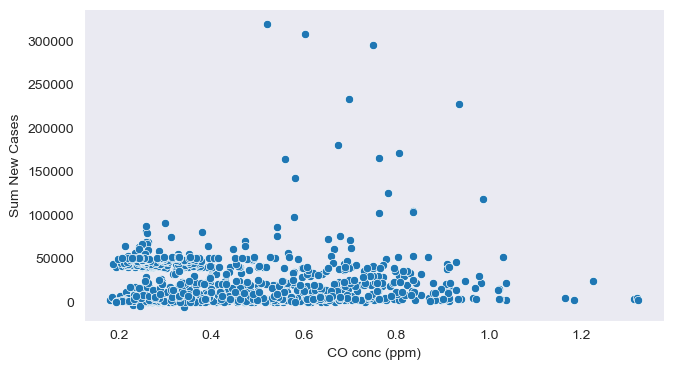

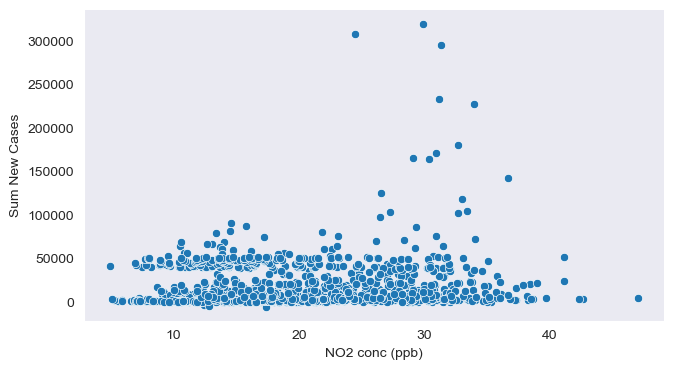

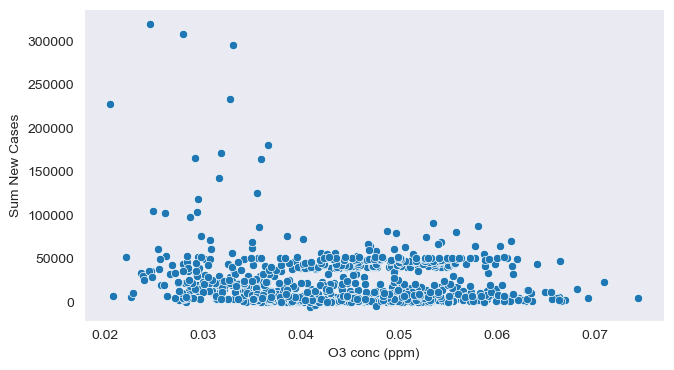

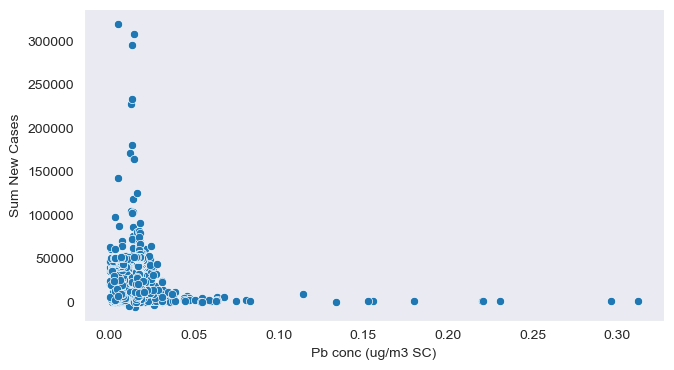

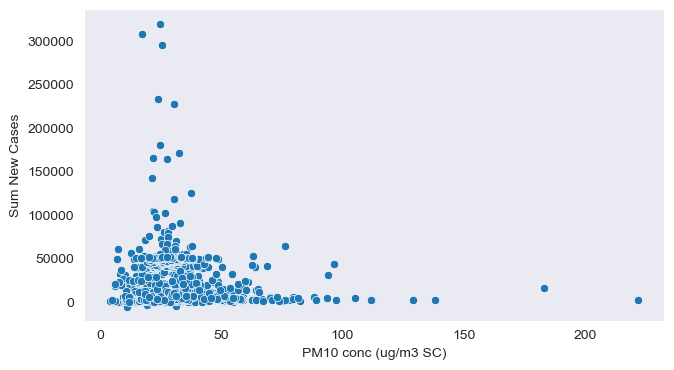

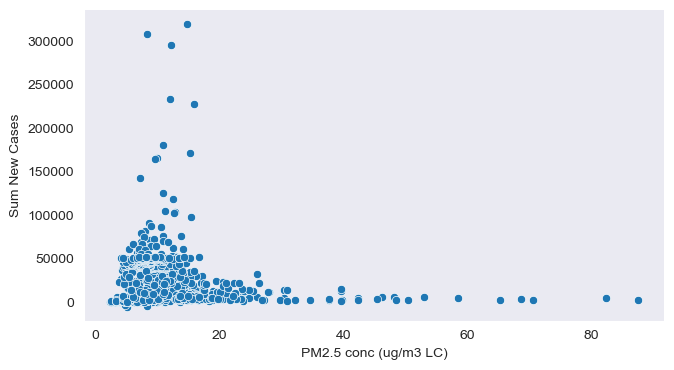

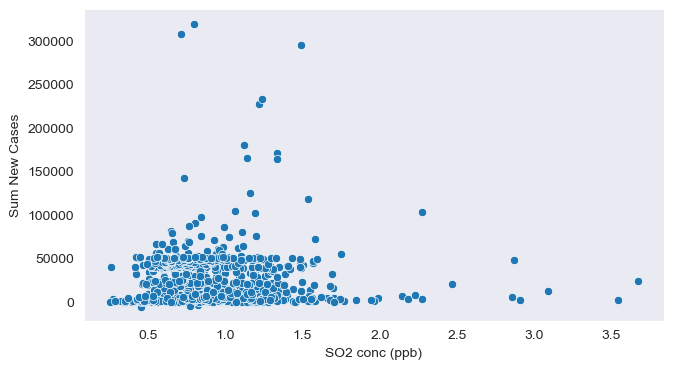

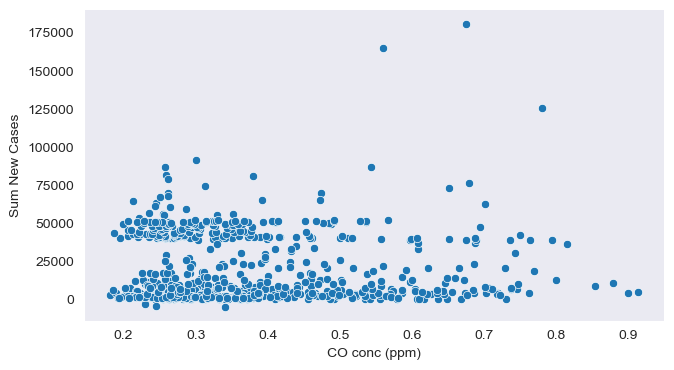

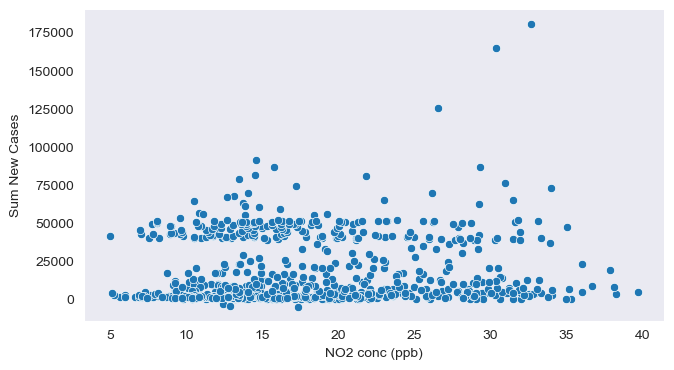

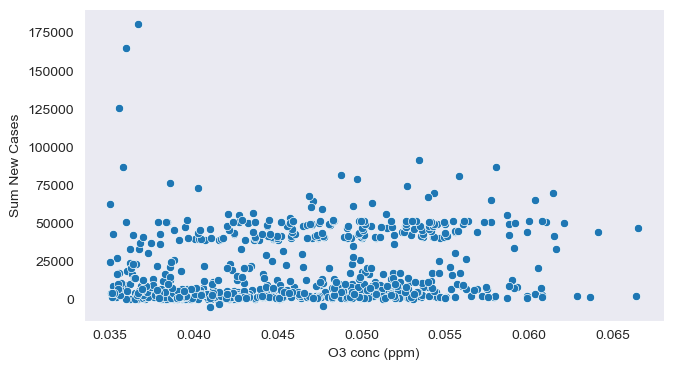

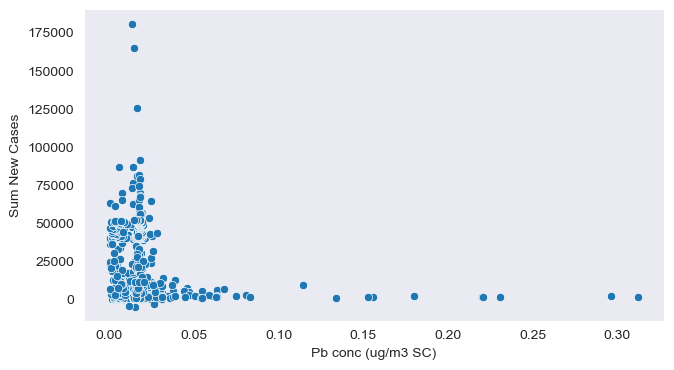

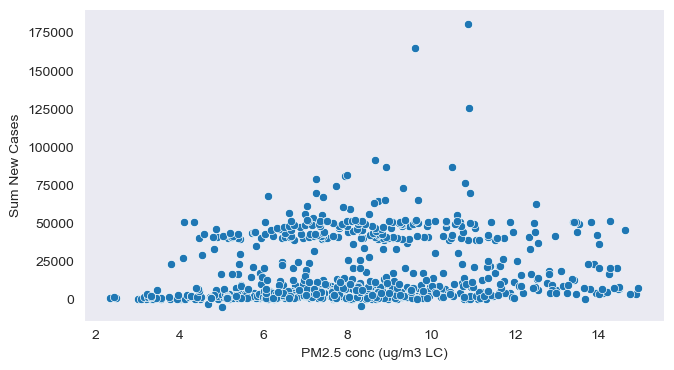

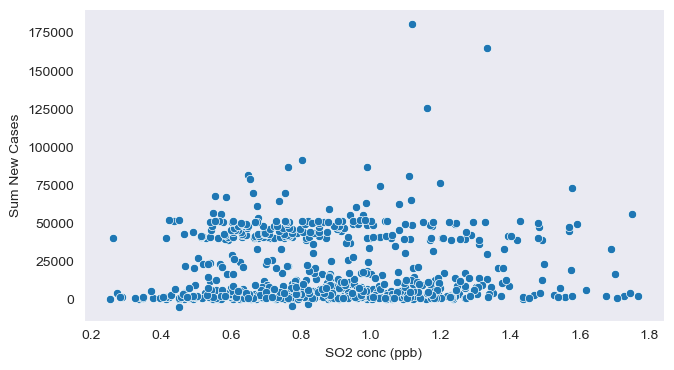

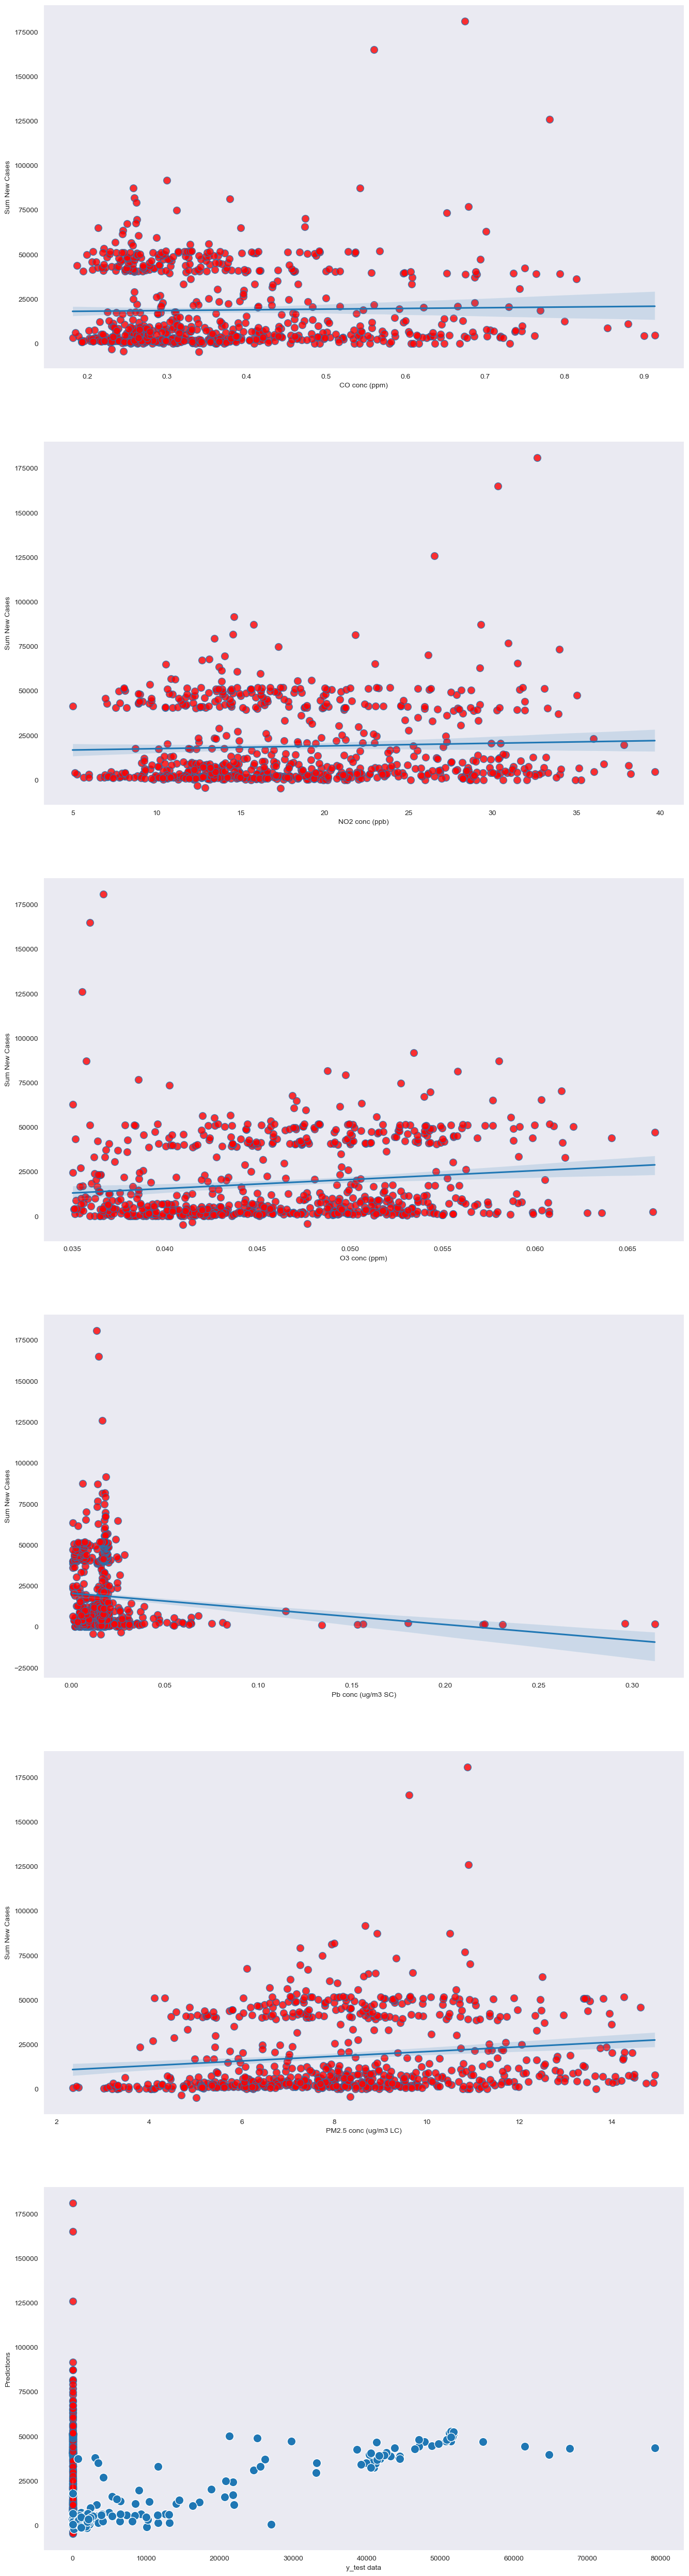

In [1]:
# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.index >= dataB.index.min()) &
              (dataA.index <= dataB.index.max())]

print("Filtered Dataset A")
dataA.head()

# Merging the two datasets (dataA & dataB)
data = dataA.merge(dataB, left_index=True, right_index=True)

# Take a peak at both contents and shape
data.head()
data.info()

import matplotlib.pyplot as plt
%matplotlib inline

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
print("Scatterplots before pruning:")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining BEFORE pruning:", data.shape[0])

# DYNAMIC PRUNING
# IDEA: We focus on ambient level of pollutants and ignore sudden spikes in COVID-19 case data (i.e. data dumps).
# We also remove Dates where there are no new infections as their volume skews the data alot.
# Currently visible values are most likely plateaus after painstaking tuning.
# data = data[(data['Sum New Cases'] <= 73000) & (data['Sum New Cases'] > 1)]
data = data[(data['Total Cases'] > 0)]
data = data[(data['Confirmed Cases'] > 0)]
data = data[data['CO conc (ppm)'] <= 1.5]
# data = data[data['NO2 conc (ppb)'] > 1]   # pruning based on some columns hurts the metrics
data = data[data['O3 conc (ppm)'] > 0.035]
data = data[data['Pb conc (ug/m3 SC)'] < 0.5]
data = data[data['PM10 conc (ug/m3 SC)'] < 100]
data = data[data['PM2.5 conc (ug/m3 LC)'] < 15]
data = data[data['SO2 conc (ppb)'] < 2.0]

# DROP COLUMNS HERE
data.drop(columns=['PM10 conc (ug/m3 SC)'], axis=1, inplace=True)
# data = data[['PM10 conc (ug/m3 SC)', 'Sum New Cases']]

# SHOW scatterplots of pruned columns
print("Scatterplots after pruning")
for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining AFTER pruning:", data.shape[0])

fig, axs = plt.subplots(nrows=len(data.columns)-3, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label in ["Sum New Cases", "Total Cases", "Confirmed Cases"]: continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

# Linear Regression
# PREPARE FEATURES AND TARGET DATA (standardize first)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
scaler = MinMaxScaler()

# SPLIT DATA TO FEATURE SET AND TARGET
X = data.iloc[:,0:-1] # feature matrix
X = scaler.fit_transform(X)
y = data.iloc[:,-1] # target vector

# PREPARE TRAINING AND TESTING DATA
# NOTE: test_size is reduced to 20% because we have few records to work with especially after pruning
# (around 499 left from roughly 1000)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
import sklearn.linear_model as sklm
regressor = LinearRegression()
alt1 = Ridge(alpha=0.5)
alt2 = SGDRegressor()
regressor.fit(X_train, y_train)
alt1.fit(X_train, y_train)
alt2.fit(X_train, y_train)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

y_pred = regressor.predict(X_test)
y_pred

y_pred1 = alt1.predict(X_test)
y_pred2 = alt2.predict(X_test)

comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

comparison_df1 = pd.DataFrame({"Actual":y_test,"Predicted":y_pred1})
comparison_df2 = pd.DataFrame({"Actual":y_test,"Predicted":y_pred2})

residuals = y_test - y_pred
residuals

residuals1 = y_test - y_pred1
residuals2 = y_test - y_pred2

sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

f = open("log2.out", "a")

from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))
dump = f.write('MAE: {}\n'.format(mean_absolute_error(y_test,y_pred)))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))
dump = f.write('MSE: {}\n'.format(mean_squared_error(y_test,y_pred)))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
dump = f.write('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric
dump = f.write('R2 Score: {}\n'.format(r2))

dump = f.write('---\n')

# FOR ALTERNATIVES
print("\nFOR ALTERNATIVES:")
print("ALT1 R2 Score:", r2_score(y_test, y_pred1))
print("ALT2 R2 Score:", r2_score(y_test, y_pred2))